# Initalize libraries

## Import libraries

In [16]:
import sys, os
import time
from os.path import join
from os import path
from importlib import reload
from getpass import getuser
import xarray as xr
import h5py
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt

# Misc
from scipy.ndimage import gaussian_filter1d

# Open nexus files
from nexusformat.nexus import *

# Self-written libraries
sys.path.append(join(os.getcwd(), "library"))
import helper_functions as helper
from interactive import cimshow

# Gifs
import imageio

# Facility specific loading functions
# import MAXI_loading as loading
import PETRA_MaxP04_loading as loading

plt.rcParams["figure.constrained_layout.use"] = True  # replaces plt.tight_layout

In [17]:
# Is there a GPU?
try:
    # Cupy
    import cupy as cp
    import cupyx as cpx

    GPU = True

    print("GPU available")

    # Self-written library
    import CCI_core_cupy as cci
    import Phase_Retrieval as PhR
except:
    GPU = False
    import CCI_core as cci

    print("GPU unavailable")

GPU unavailable


In [18]:
# interactive plotting
import ipywidgets

%matplotlib widget

# Auto formatting of cells
%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


## Experiment specific Functions

In [4]:
PROPOSAL = 11021367
USER = getuser()

BASEFOLDER = "/asap3/petra3/gpfs/p04/2024/data/%s/" % PROPOSAL
# subfolder = "2403_tomo_"
file_prefix = "2409_laser_"

# Load mnemonics for easy data handling
mnemonics = loading.mnemonics

### Loading data

In [5]:
# Load image files
def load_images(im_id):
    """
    Load ccd images from nxs files
    """

    fname = join(BASEFOLDER, "raw", "%s_%05d.h5" % (file_prefix, im_id))

    with nxload(fname) as f:
        im_out = np.array(f["scan"]["data"]["ccd"][()])
        print("Loaded: %s (%d frames)" % (fname, im_out.shape[0]))
    return im_out.squeeze()


# Load any kind of data from collection
def load_collection(scan_id, field):
    fname = join(BASEFOLDER, "raw", "%s_%05d.h5" % (file_prefix, scan_id))

    with nxload(fname) as f:
        data = np.array(f["scan"]["instrument"]["collection"][field][()])
        print("Loaded: %s" % (fname))
    return np.squeeze(data)


# Load mono energy
def load_energy(scan_id):
    fname = join(BASEFOLDER, "raw", "%s_%05d.h5" % (file_prefix, scan_id))

    with nxload(fname) as f:
        data = np.array(f["scan"]["instrument"]["monochromator"]["energy"][()])
        print("Loaded: %s" % (fname))
    return np.squeeze(data)


# Load any kind of data from measurements
def load_data(scan_id, field):
    fname = join(BASEFOLDER, "raw", "%s_%05d.h5" % (file_prefix, scan_id))

    with nxload(fname) as f:
        data = np.array(f["scan"]["data"][field][()])
        print("Loaded key %s of %s" % (field, fname))
    return np.squeeze(data)

In [6]:
def load_data(scan_id, keypath=mnemonics["measurement"], keys=None):
    """
    Load data of all specified keys from keypath

    Parameter
    =========
    scan_id : int
        experimental identifier of scan
    keypath : str
        path of nexus file tree to relevant data field
    keys : str or list of strings
        keys to load from keypath

    Output
    ======
    data : dict
        data dictionary of keys
    ======
    author: ck 2024
    """

    # Generate filename from scan_id
    fname = loading.generate_filename(
        join(BASEFOLDER, "raw"), file_prefix, ".h5", scan_id
    )

    # load data with basic loading function
    data = loading.load_data(fname, keypath, keys=keys)

    return data


def load_key(scan_id, key):
    """
    Load any kind of data specified by key (path)

    Parameter
    =========
    scan_id : int
        experimental identifier of scan
    key : str
        key path of nexus file tree to relevant data field

    Output
    ======
    data : dict
        data dictionaray on single key
    ======
    author: ck 2024
    """
    # Generate filename from scan_id
    fname = loading.generate_filename(
        join(BASEFOLDER, "raw"), file_prefix, ".h5", scan_id
    )

    # load data with basic loading function
    data = loading.load_key(fname, key)

    return data

In [7]:
# Not implemented yet
def norm_hyst_data(ydata, norm):
    """
    Normalize hysteresis yaxis to +/- 1
    """
    ynorm = []
    for i in range(len(ydata)):
        tmp = ydata[i] / norm[i]
        tmp = tmp - np.mean(tmp[-5:])
        tmp = tmp / np.mean(tmp[:5])
        tmp = 2 * (tmp - 0.5)
        ynorm.append(tmp)

    return ynorm

In [8]:
# For fitting of peaks with a gaussian
from scipy.optimize import curve_fit


def gaussian(x, a, x0, sigma, c):
    return a * np.exp(-((x - x0) ** 2) / (2 * sigma**2)) + c

# Experimental Details

In [9]:
# General saving folder
folder_general = helper.create_folder(join(BASEFOLDER, "processed"))
print("Output Folder: %s" % folder_general)

Output Folder: /asap3/petra3/gpfs/p04/2024/data/11021367/processed


# Single or combination of multiple diode scans

In [30]:
# Add scan numbers to combine in single plot
scan_ids = [150]  # np.arange(1800,1806)

# keys from nxs files (if you are not sure, which you need, open nexus files from beamtime folder and navigate through keys `2310_P04_FGT/raw/FGT`)
data_key_x = "msx"  # "mx" # "energy", "sx", "sy"
data_key_y = "fADC_diodemax"  # "adc_beck_femto_diodemax"#"mx"#"sz"#fADC_diodemax

# Normalization of diode signal with I0, e.g., with petra current or gold mesh (needs to be inserted during scan)
normalization = False
data_key_norm = "maxibeckhoff1adc2_rmean"  # "petra_curr"

# Load data
xdata, ydata, norm = [], [], []
for scan_id in tqdm(scan_ids):
    xdata.append(load_data(scan_id)[data_key_x])
    ydata.append(load_data(scan_id)[data_key_y])

    if normalization is True:
        norm.append(load_data(scan_id)[data_key_norm])
    else:
        norm.append(np.ones(ydata[-1].shape))

  0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
# Filter values from ydata which are only zeros
for i, scan_id in enumerate(scan_ids):
    idx_filter = ydata[i] > 0.0001
    ydata[i] = ydata[i][idx_filter]
    xdata[i] = xdata[i][idx_filter]
    norm[i] = norm[i][idx_filter]

Saving: /asap3/petra3/gpfs/p04/2024/data/11021367/processed/ScanId_0150_Diode_cklose.png


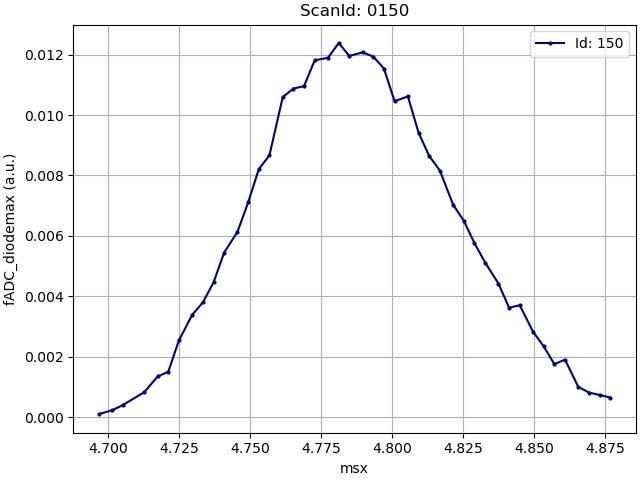

In [32]:
# Format title and output file name
if len(scan_ids) > 1:
    title = "ScanIds: %04d-%04d" % (scan_ids[0], scan_ids[-1])
    fname = join(
        folder_general,
        "ScanId_%04d-%04d_Diode_%s.png" % (scan_ids[0], scan_ids[-1], USER),
    )
else:
    title = "ScanId: %04d" % (scan_ids[0])
    fname = join(folder_general, "ScanId_%04d_Diode_%s.png" % (scan_ids[0], USER))

# Color scheme if there a multiple scans
colors = plt.cm.jet(np.linspace(0, 1, len(xdata)))

# Plot all scans together
fig, ax = plt.subplots()

# Iterate over scans
for i, _ in enumerate(scan_ids):
    ax.plot(
        xdata[i],
        ydata[i] / norm[i],
        "o-",
        markersize=2,
        label="Id: %d" % scan_ids[i],
        color=colors[i],
    )

# Plotting options
ax.set_title(title)
ax.set_xlabel(data_key_x)
# ax.set_xlim([-0.01, 0.01])
# ax.set_ylim([-0.015, 0.015])
ax.grid()
ax.legend()

# Different label with and without normalization
if normalization is True:
    ax.set_ylabel(data_key_y + " (normalized by %s)" % data_key_norm, fontsize=7)
else:
    ax.set_ylabel(data_key_y + " (a.u.)")

# Save plot
print("Saving: %s" % fname)
plt.savefig(fname, dpi=300)

## Fitting of scans with a gaussian

In [22]:
# Add scan numbers to combine in single plot
scan_ids = [95, 146]

# keys from nxs files (if you are not sure, which you need, open nexus files from beamtime folder and navigate through keys `2310_P04_FGT/raw/FGT`)
data_key_x = "msz"
data_key_y = "fADC_diodemax"
data_key_pre_scan = "div"

# Normalization of diode signal with I0, e.g., with petra current or gold mesh (needs to be inserted during scan)
normalization = False
data_key_norm = "maxibeckhoff1adc2_rmean"  # "petra_curr"

# Load data
xdata, ydata, norm, pre_scan_snapshots = [], [], [], []
for scan_id in tqdm(scan_ids):
    xdata.append(load_data(scan_id)[data_key_x])
    ydata.append(load_data(scan_id)[data_key_y])

    if normalization is True:
        norm.append(load_data(scan_id)[data_key_norm])
    else:
        norm.append(np.ones(ydata[-1].shape))

# Other
pre_scan_values = [-3, -4, -3.5, -2.0, -1.0, 0, -2.5]

  0%|          | 0/2 [00:00<?, ?it/s]

In [23]:
# Filter values from ydata which are only zeros
for i, scan_id in enumerate(scan_ids):
    idx_filter = ydata[i] > 0.0001
    ydata[i] = ydata[i][idx_filter]
    xdata[i] = xdata[i][idx_filter]
    norm[i] = norm[i][idx_filter]

Scan 95: A=1.180859, x=51.094066, sigma=0.036869, c=-0.038409
Scan 146: A=1.220561, x=51.178804, sigma=0.026884, c=-0.005982
Saving: /asap3/petra3/gpfs/p04/2024/data/11021367/processed/ScanId_0095-0146_Fit_cklose.png


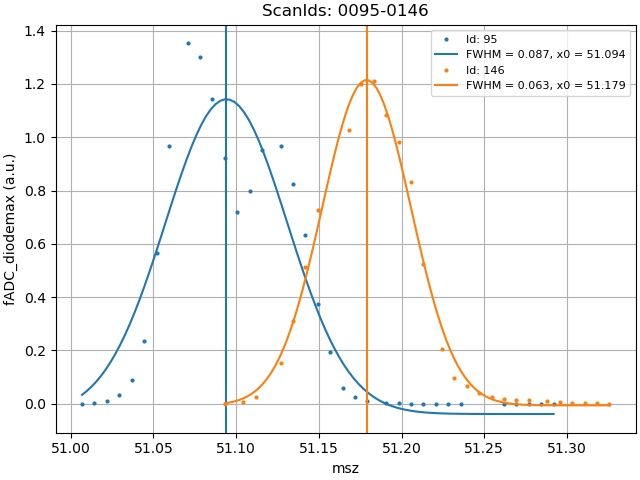

In [24]:
# Format title and output file name
if len(scan_ids) > 1:
    title = "ScanIds: %04d-%04d" % (scan_ids[0], scan_ids[-1])
    fname = join(
        folder_general,
        "ScanId_%04d-%04d_Fit_%s.png" % (scan_ids[0], scan_ids[-1], USER),
    )
else:
    title = "ScanId: %04d" % (scan_ids[0])
    fname = join(folder_general, "ScanId_%04d_Fit_%s.png" % (scan_ids[0], USER))


# Plot all scans together
fig, ax = plt.subplots()

fit = True

popt_list = []

# Iterate over scans
for i, scan_id in enumerate(scan_ids):
    # Plot diode
    y = ydata[i] / norm[i]
    p = ax.plot(
        xdata[i],
        y,
        "o",
        markersize=2,
        label="Id: %d" % scan_ids[i],
    )

    # Initial fitting Parameter
    if fit is True:
        A0 = np.max(ydata[i] / norm[i])
        x0 = xdata[i][np.argmax(ydata[i])]
        sigma0 = 0.1
        c0 = 0  # np.min(ydata[i])
        popt, pcov = curve_fit(gaussian, xdata[i], y, p0=(A0, x0, sigma0, c0))
        # popt returns the best fit values for parameters of the given model (func)
        print(
            "Scan %d: A=%02f, x=%02f, sigma=%02f, c=%02f"
            % (scan_id, popt[0], popt[1], popt[2], popt[3])
        )
        color = p[0].get_color()
        # plot fit
        x = np.linspace(xdata[i][0], xdata[i][-1], 100)
        ym = gaussian(x, popt[0], popt[1], popt[2], popt[3])
        ax.plot(
            x,
            ym,
            color=color,
            label="FWHM = %.3f, x0 = %.3f"
            % (2 * np.sqrt(2 * np.log(2)) * popt[2], popt[1]),
        )

        # Add vline line
        ax.axvline(popt[1], 0, 10, color=color)

        # Add monitoring values
        popt_list.append(popt)

# Plotting options
ax.set_title(title)
ax.set_xlabel(data_key_x)
# ax.set_xlim([-0.01, 0.01])
# ax.set_ylim([-0.015, 0.015])
ax.grid()
ax.legend(fontsize=8)

# Different label with and without normalization
if normalization is True:
    ax.set_ylabel(data_key_y + " (normalized by %s)" % data_key_norm, fontsize=7)
else:
    ax.set_ylabel(data_key_y + " (a.u.)")

# Save plot
print("Saving: %s" % fname)
plt.savefig(fname)

Saving: /asap3/petra3/gpfs/p04/2024/data/11021367/processed/ScanId_0100-0119_Fit_amp_cklose.png


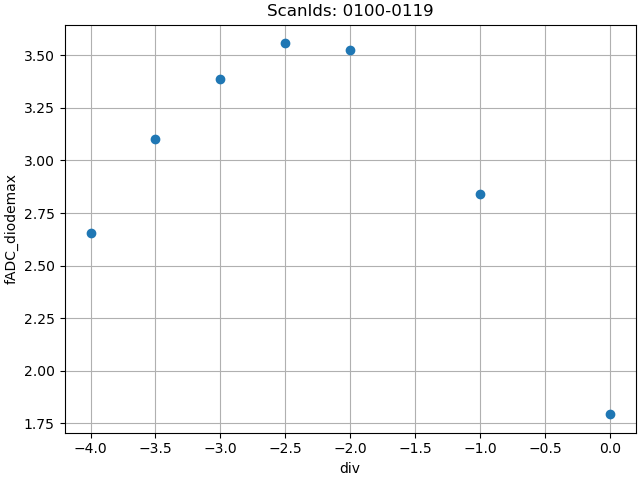

In [15]:
amp, x0, std, offset = zip(*popt_list)

fig, ax = plt.subplots()
ax.plot(pre_scan_values, amp, "o")
ax.set_xlabel("div")
ax.set_ylabel(data_key_y)
ax.grid()
ax.set_title(title)

# Save plot
fname = join(
    folder_general,
    "ScanId_%04d-%04d_Fit_amp_%s.png" % (scan_ids[0], scan_ids[-1], USER),
)
print("Saving: %s" % fname)
plt.savefig(fname)

## Other

# Rotation scans

In [ ]:
# Add scan numbers to combine in single plot
scan_ids = [883,890,893,898,901,904,907,910,915,918,921,924,929,932,935]
#scan_ids = [882,889,894,896,900,903,906,909,914,917,920,923,928,931,934]

# keys from nxs files (if you are not sure, which you need, open nexus files from beamtime folder and navigate through keys `2310_P04_FGT/raw/FGT`)
data_key_x = "sy" # "energy", "sx", "sy"
data_key_y = "maxibeckhoff1adc1_rmean"
rot_key = "srotz"


# Normalization of diode signal with I0, e.g., with petra current or gold mesh (needs to be inserted during scan)
normalization = False
data_key_norm = "maxibeckhoff1adc2_rmean"  # "petra_curr"


if rot_key == "srotz":
    angle0 = 67

# Load data
xdata, ydata, norm, rot = [], [], [], []
for scan_id in tqdm(scan_ids):
    xdata.append(load_data(scan_id, data_key_x))
    ydata.append(load_data(scan_id, data_key_y))
    rot.append(load_pre_scan_snapshot(scan_id, rot_key))

    if normalization is True:
        norm.append(load_data(scan_id, data_key_norm))
    else:
        norm.append(np.ones(ydata[-1].shape))

In [ ]:
# Format title and output file name
if len(scan_ids) > 1:
    title = "ScanIds: %04d-%04d" % (scan_ids[0], scan_ids[-1])
    fname = join(
        folder_general,
        "ScanId_%04d-%04d_Diode_rot_%s.png" % (scan_ids[0], scan_ids[-1], USER),
    )
else:
    title = "ScanId: %04d" % (scan_ids[0])
    fname = join(folder_general, "ScanId_%04d_Diode__rot%s.png" % (scan_ids[0], USER))

colors = plt.cm.jet(np.linspace(0,1,len(xdata)))

# Plot all scans together
fig, ax = plt.subplots()

# Iterate over scans
for i, _ in enumerate(scan_ids):
    ax.plot(
        xdata[i],
        ydata[i] / norm[i],
        "o-",
        markersize=2,
        label="Id: %d, %s: %.1f (%.1f deg)" % (scan_ids[i],rot_key,rot[i],rot[i]-angle0),
        color = colors[i]
    )

# Plotting options
ax.set_title(title)
ax.set_xlabel(data_key_x)
# ax.set_xlim([-0.01, 0.01])
# ax.set_ylim([-0.015, 0.015])
ax.grid()
ax.legend(fontsize = 7)

# Different label with and without normalization
if normalization is True:
    ax.set_ylabel(data_key_y + " (normalized by %s)" % data_key_norm, fontsize=7)
else:
    ax.set_ylabel(data_key_y + " (a.u.)")

# Save plot
print("Saving: %s" % fname)
plt.savefig(fname, dpi=300)

In [ ]:
peaks_x = np.stack(xdata)
peaks_y = np.stack(ydata)

peak_pos = []
for i,argmax in enumerate(np.argmax(peaks_y,axis=1)):
    peak_pos.append(peaks_x[i,argmax])

# Fitting
m,b = np.polyfit(rot, peak_pos, 1)
x = np.linspace(25,125,180)

sy = m*x+b
    
fig, ax = plt.subplots()
ax.plot(rot,peak_pos,"o",
        markersize=7,)
        #label="Id: %d, %s: %.1f (%.1f deg)" % (scan_ids[i],rot_key,rot[i],rot[i]-angle0))
ax.plot(x,sy,label = "Fit: %s = %.2f * %s + %.2f"%(data_key_x,m,rot_key,b))
ax.set_ylabel(data_key_x)
ax.set_xlabel(rot_key)
ax.set_title("Alignment Peak Position")
ax.grid()
ax.legend()

fname = join(
    folder_general,
    "ScanId_%04d-%04d_Diode_rot_peak_%s.png" % (scan_ids[0], scan_ids[-1], USER),
)
print("Saving: %s"%fname)

plt.savefig(fname)

In [ ]:
input_angle = 42
sy = m*input_angle+b
sy

# Other

# Diode Trace Hysteresis

In [ ]:
def ramp_tan(npts: int, s: float, full=False):
    """Calculate truncated tangent ramp function.

    Parameters
    ==========
    npts: int
        Number of points to calculate
    s: float
        shape parameter (0<s≤1) varies curve from linear (s→0) to tan-shaped
    full: bool
        If True, return both arms of the loop by mirroring. This effectively
        doubles the number of points.

    Returns
    =======
    ramp: np.ndarray
        normalized ramp values
    """
    # if (s <= 0) or (s > 1):
    #     raise ValueError("shape parameter out of range 0<s≤1")
    x = s * np.linspace(-np.pi / 2, np.pi / 2, npts)
    y = np.tan(x) / np.tan(np.pi * s / 2)
    if full:
        y = np.append(y, y[::-1][1:])
    return y

In [ ]:
def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

In [ ]:
# Choose scan id
scan_id = 2511

# Load trace data
fields = [
    f"adc_beck_femto_diodemax_trace",
    "adc_beck_femto_goldmesh_trace",
    "adc_beck_mtesla_trace",
]
adcs = [load_data(scan_id, f) for f in fields]

In [ ]:
# Create xarray dataset
ds = xr.Dataset()
ds["fields"] = ("index", adcs[2][:, 10:-10].flatten())  # magnetic field
ds["diode"] = ("index", adcs[0][:, 10:-10].flatten())  # diode current
ds["mesh"] = ("index", adcs[1][:, 10:-10].flatten())  # mesh current for normalization
ds["rising"] = (
    "index",
    gaussian_filter1d(np.gradient(ds["fields"]), 20) > 0,
)  # which hysteresis branch

In [ ]:
bins = np.max(ds.fields.values) * ramp_tan(100, 0.5, False)

ds_sel = ds
ds_sel["rising"] = ds_sel.rising.astype(bool)
up = ds_sel.where(ds_sel.rising).groupby_bins("fields", bins).mean()
down = ds_sel.where(~ds_sel.rising).groupby_bins("fields", bins).mean()

In [ ]:
fig, ax = plt.subplots()
ax.plot(1e2 * up.fields, 2 * normalize(up.diode / up.mesh) - 1, "o", ms=3)
ax.plot(1e2 * down.fields, 2 * normalize(down.diode / down.mesh) - 1, "o", ms=3)
ax.set_xlabel("field (mT)")
ax.set_ylabel("diode / mesh (arb. units)")
ax.set_title("scan %d: field sweep @ 0.2Hz" % (scan_id))
ax.grid()

fname = join(folder_general, "ScanId_%04d_Diode_Trace_%s.png" % (scan_id, USER))
print("Saving: %s" % fname)
plt.savefig(fname, dpi=300)